In [1]:
# Copy and run the code you wrote in task 1 notebook here
!pip install transformers datasets accelerate bitsandbytes
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import torch
import tensorflow as tf

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/10.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.1 MB 2.4 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/10.1 MB 1.5 MB/s eta 0:00:07
   ---- ----------------------------------- 1.0/10.1 MB 1.5 MB/s eta 0:00:06
   ---- ----------------------------------- 1.0/10.1 MB 1.5 MB/s eta 0:00:06
   ------ --------------------------------- 1.6/10.1 MB 1.3 MB/s eta 0:00:07
   ------- -------------------------------- 1.8/10.1 MB 1.4 MB/s eta 0:00:06
   --------- ------------------------------ 2.4/10.1 MB 1.5 MB/s eta 0:00:06
   ----------- ---------------------------- 2.9/10.1 MB 1.6 MB/s eta 0:00:05
   ------------- -------------------------- 3.4/10.1 MB 1.8 MB/s eta 0:00:04
   --------------- ------------------------ 3.9/10.1 MB 1.8 MB/s eta 0:00:04
   ---------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


RuntimeError: Failed to import transformers.trainer because of the following error (look up to see its traceback):
Failed to import transformers.integrations.integration_utils because of the following error (look up to see its traceback):
Failed to import transformers.modeling_tf_utils because of the following error (look up to see its traceback):
Your currently installed version of Keras is Keras 3, but this is not yet supported in Transformers. Please install the backwards-compatible tf-keras package with `pip install tf-keras`.

In [3]:
''' Do not change this cell '''
#Functions

def check_gpu():
  if tf.test.gpu_device_name() != '':
    print("GPU sucessfully connected")
  else: print("PLease connect GPU")


#Setup and check a gpu connection.

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU detected. Please enable GPU runtime.")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Checking connection by running
x = torch.tensor([1.0, 2.0, 3.0]).to(device)
print(x)

''' Do not change this cell '''
check_gpu()



NameError: name 'torch' is not defined

# **#Task 2**

Data Preprocessing : 1. Reformat the dataset into Llama 2 chat model template
<br>
                     2. Push the reformated data to Hugging Face Hub ( This dataset will be used further)

Following is the prompt template of Llama 2 chat model

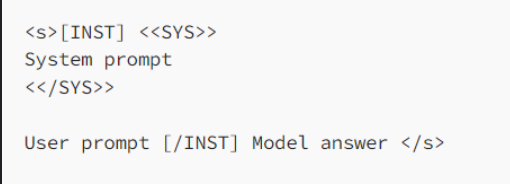


In [ ]:
#Here goes the code for data preprocessing

from datasets import load_dataset


dataset = load_dataset("jizzu/llama2_indian_law_v2", download_mode="force_redownload")

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

# Referred to a Comprehensive article by Philschmid

https://www.philschmid.de/fine-tune-llms-in-2024-with-trl

From the blog post, the key points related to reformatting datasets to a chat template for fine-tuning LLMs were:

1. Create and Prepare the Dataset
A well-constructed dataset tailored to the use case is critical for effective fine-tuning.
Datasets should include:
Natural language instructions (input prompts).
Expected responses (output).
Any contextual information (e.g., schema definitions for SQL).
Convert the data into a conversational format to align with the model's input-output structure, ensuring compatibility for fine-tuning.
2. Fine-Tuning Tools
Use Hugging Face's SFTTrainer for features like dataset packing, which helps in efficiently structuring data for training.
Ensure data format aligns with the model's expected conversational style (e.g., instruction-prompt and response separation).
This highlights the importance of structuring datasets properly and the tools available to streamline this process during fine-tuning.

In [ ]:
import csv


# We add a system prompt.
#This prompt takes into account the purpose of our LLM


system_prompt = "You are a helpful assistant specialized in Indian law."

# Function to reformat to our chat template

#Logic: We take a list named formatted_data.
# We then iterate over the original data - Which is of the following format:
# {'text': '###Human: <User Prompt> ###Assistant: <Model Response>'}
# We get the text, and then split the ###Human and ###Assistant part
# We restructure it in the correct format and append it to the formatted_data list
#           <s>[INST] <<SYS>>\n{system_prompt}\n<<SYS>>\n"
#           {user_prompt} [/INST]\n"
#           {model_answer} </s>"




def reformat_to_chat_template(raw_data, system_prompt):
    formatted_data = []
    for entry in raw_data:
        text = entry.get("text", "")

        if "###Human:" in text and "###Assistant:" in text:
            user_prompt = text.split("###Human:")[1].split("###Assistant:")[0].strip()
            model_answer = text.split("###Assistant:")[1].strip()


            formatted_entry = (
                f"<s>[INST] <<SYS>>\n{system_prompt}\n<<SYS>>\n"
                f"{user_prompt} [/INST]\n"
                f"{model_answer} </s>"
            )
            formatted_data.append({"formatted_text": formatted_entry})
    return formatted_data


# We call the reformat_to_chat_template function for each of the train,test and validation split
# We then save each of these in csv format which would then be uploaded to HuggingFace


for split_name in ["train", "validation", "test"]:
    split = dataset[split_name]
    formatted_split = reformat_to_chat_template(split, system_prompt)

    output_file = f"{split_name}.csv"
    with open(output_file, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["formatted_text"])
        writer.writeheader()
        writer.writerows(formatted_split)
    print(f"Reformatted {split_name} data saved to {output_file}")


In [ ]:
import csv
import re

# Define a reusable system prompt
SYSTEM_PROMPT = "You are a helpful assistant specialized in Indian law."

# Function to reformat data into the chat template format
# Explanation:
# 1. This version uses a regular expression to improve reliability when splitting
#    text into "###Human" and "###Assistant" parts.
# 2. It logs malformed entries for debugging instead of skipping silently.
def reformat_to_chat_template(raw_data, system_prompt):
    """
    Reformats raw data into the chat template format.

    Args:
        raw_data (list of dict): List of entries containing 'text' to be reformatted.
        system_prompt (str): System prompt to include in the reformatted data.

    Returns:
        list of dict: Reformatted data with keys "formatted_text".
    """
    formatted_data = []

    # Regex pattern to split "###Human:" and "###Assistant:"
    # This makes the parsing more robust compared to simple string splitting.
    pattern = re.compile(r"###Human:(.*?)###Assistant:(.*)", re.DOTALL)

    for entry in raw_data:
        text = entry.get("text", "").strip()

        # Using regex to match the expected structure
        match = pattern.search(text)

        if match:
            user_prompt = match.group(1).strip()
            model_answer = match.group(2).strip()

            formatted_entry = (
                f"<s>[INST] <<SYS>>\n{system_prompt}\n<<SYS>>\n"
                f"{user_prompt} [/INST]\n"
                f"{model_answer} </s>"
            )
            formatted_data.append({"formatted_text": formatted_entry})
        else:
            # Log entries that do not match the expected format for debugging
            print(f"Skipping malformed entry: {text[:50]}...")

    return formatted_data

# Function to save formatted data to a CSV file
# Explanation: This function is separated for better modularity and reusability.
def save_to_csv(data, file_name):
    """
    Saves formatted data to a CSV file.

    Args:
        data (list of dict): List of entries to be saved.
        file_name (str): Name of the output CSV file.
    """
    with open(file_name, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["formatted_text"])
        writer.writeheader()  # Add header for CSV file
        writer.writerows(data)  # Write all formatted data rows
    print(f"Data saved to {file_name}")

# Processing each split (train, validation, test)
# Explanation:
# - Added safeguards for missing or empty dataset splits.
# - Each stage is modular for readability and debugging.
for split_name in ["train", "validation", "test"]:
    split = dataset.get(split_name, [])

    if not split:
        # Log if a dataset split is missing or empty
        print(f"No data found for split: {split_name}")
        continue


    formatted_split = reformat_to_chat_template(split, SYSTEM_PROMPT)


    output_file = f"{split_name}.csv"
    save_to_csv(formatted_split, output_file)


# Optimised Approach

## Improvements:

1. **Error Handling**: Added checks to ensure data integrity and handle cases where the expected format is not found.
2. **String Processing**: Used regex for splitting to improve robustness.
3. **Logging**: Added informative messages for better traceability.
4. **Code Readability**: Improved variable naming and modularized repetitive logic.
5. **Output Encoding**: Ensured proper UTF-8 encoding for the CSV files.

In [ ]:
import csv
import re

# Define a reusable system prompt
SYSTEM_PROMPT = "You are a helpful assistant specialized in Indian law."

# Function to reformat data into the chat template format
# Explanation:
# 1. This version uses a regular expression to improve reliability when splitting
#    text into "###Human" and "###Assistant" parts.
# 2. It logs malformed entries for debugging instead of skipping silently.
def reformat_to_chat_template(raw_data, system_prompt):
    """
    Reformats raw data into the chat template format.

    Args:
        raw_data (list of dict): List of entries containing 'text' to be reformatted.
        system_prompt (str): System prompt to include in the reformatted data.

    Returns:
        list of dict: Reformatted data with keys "formatted_text".
    """
    formatted_data = []

    # Regex pattern to split "###Human:" and "###Assistant:"
    # This makes the parsing more robust compared to simple string splitting.
    pattern = re.compile(r"###Human:(.*?)###Assistant:(.*)", re.DOTALL)

    for entry in raw_data:
        text = entry.get("text", "").strip()

        # Using regex to match the expected structure
        match = pattern.search(text)

        if match:
            user_prompt = match.group(1).strip()
            model_answer = match.group(2).strip()

            formatted_entry = (
                f"<s>[INST] <<SYS>>\n{system_prompt}\n<<SYS>>\n"
                f"{user_prompt} [/INST]\n"
                f"{model_answer} </s>"
            )
            formatted_data.append({"formatted_text": formatted_entry})
        else:
            # Log entries that do not match the expected format for debugging
            print(f"Skipping malformed entry: {text[:50]}...")

    return formatted_data

# Function to save formatted data to a CSV file
# Explanation: This function is separated for better modularity and reusability.
def save_to_csv(data, file_name):
    """
    Saves formatted data to a CSV file.

    Args:
        data (list of dict): List of entries to be saved.
        file_name (str): Name of the output CSV file.
    """
    with open(file_name, "w", newline="", encoding="utf-8") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=["formatted_text"])
        writer.writeheader()  # Add header for CSV file
        writer.writerows(data)  # Write all formatted data rows
    print(f"Data saved to {file_name}")

# Processing each split (train, validation, test)
# Explanation:
# - Added safeguards for missing or empty dataset splits.
# - Each stage is modular for readability and debugging.
for split_name in ["train", "validation", "test"]:
    split = dataset.get(split_name, [])

    if not split:
        # Log if a dataset split is missing or empty
        print(f"No data found for split: {split_name}")
        continue


    formatted_split = reformat_to_chat_template(split, SYSTEM_PROMPT)


    output_file = f"{split_name}.csv"
    save_to_csv(formatted_split, output_file)
